# Hierarchical Clustering
**Written by Christian Alis**

- Hierarchical is more interpretable than K-means
- Hierarchical handles categorical also
- Ward's still assumes convex data



- in choosing k, sometimes looking at the dendrogram is not enough, you must also plot the points (scatter)

Representative-based clustering methods are flat clustering methods. You tell them to cluster data points into $k$ clusters and they will assign a point into exactly one cluster. Hierarchical clustering methods, on the other hand, assign points to a branch of a tree. Instead of having a priori value of $k$, it can be set after analysis, depending on where in the tree (hierarchy) you want to be.

There are two main types of hierarchical clustering:
* **Agglomerative clustering**: bottom-up approach where smaller clusters are merged with nearby clusters
* **Divisive clustering**: top-down approach where clusters are successively partitioned into smaller clusters

In this notebook, we will study four agglomerative clustering methods.

# Sample datasets

We will make use of the same datasets we investigated last time.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.testing.compare import compare_images
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from IPython.display import HTML

In [81]:
data_wine = load_wine()
standard_scaler = StandardScaler()
X_wine = standard_scaler.fit_transform(data_wine['data'])
target_wine = data_wine['target']

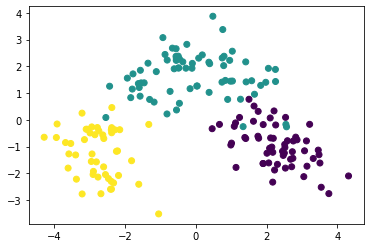

In [82]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=target_wine);

In [83]:
data_newsgroups = fetch_20newsgroups(
    subset='train', 
    categories=['comp.graphics', 'rec.autos'],
    shuffle=False, 
    remove=['headers', 'footers', 'quotes'])
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words='english',
                                   min_df=5)
bow_ng = tfidf_vectorizer.fit_transform(data_newsgroups['data'])
nonzeros = bow_ng.sum(axis=1).nonzero()[0]
bow_ng = bow_ng[nonzeros]
target_ng = data_newsgroups['target'][nonzeros]

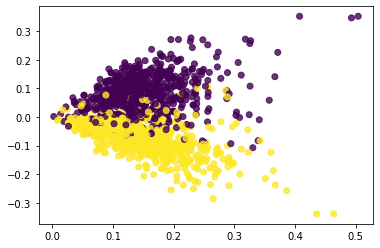

In [84]:
X_ng_new = (TruncatedSVD(n_components=2, random_state=1337)
                .fit_transform(bow_ng))
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=target_ng, alpha=0.8);

# Agglomerative clustering

This is the generic agglomerative clustering algorithm:

**Algorithm** *AgglomerativeClustering*(Database: $D$)  
**begin**  
$\quad$Initialize $n \times n$ distance metric $M$ using $D$;  
$\quad$Assign each $i \in D$ to its own cluster;  
$\quad$**repeat**  
$\quad$$\quad$Pick closest pair of clusters $i$ and $j$ using $M$;  
$\quad$$\quad$Merge clusters $i$ and $j$;  
$\quad$$\quad$Delete rows/columns $i$ and $j$ from $M$ and create a new row and column for newly merged cluster;  
$\quad$$\quad$Update the entries of new row and column of $M$;  
$\quad$**until** termination criterion;  
$\quad$**return** clustering;  
**end**

Different agglomerative clustering methods differ on how they compute the distance between clusters. The different cluster distance measures are:

* **Change in SSE**: increase in the sum-of-squared errors when the clusters are merged
* **Single linkage**: smallest distance between a point from one cluster to any point in the other cluster
* **Complete linkage**: farthest distance between a point from one cluster to any point in the other cluster
* **Group-average linkage**: average intercluster distance
* **Centroid**: distance between cluster centroids
* **Change in cluster variance**: increase in the objective function (cluster variance) when the clusters are merged

We will only discuss the first four measures in this notebook.

## Ward's method

- Take note of distance metric?
- delta is always increasing
- horizontal lines in dendogram represent the merging of clusters
- vertical lines in dendrogram represent the delta
- 0.8\*Y-axis is the basis of the threshold/cut-off in dendrogram

The first agglomerative method that we will study is Ward's method. This method defines the distance between two clusters, $A$ and $B$, as the amount the sum of squares will increase when we merge them:

$$
\Delta(A, B) = \sum_{i \in A \bigcup B} \|x_i - m_{A \bigcup B}\|^2 - \sum_{i \in A} \|x_i - m_A\|^2 - \sum_{i \in B} \|x_i - m_B\|^2
$$

where $m_j$ is the center of cluster $j$, and $n_j$ is the number of points in it. $\Delta$ is the merging cost of combining the clusters $A$ and $B$. Starting from individual points as a cluster, the method merges them while trying to minimize the growth of $\Delta$. Given two pairs of clusters whose centers are equally far apart, Ward’s method will prefer to merge the smaller ones. Note that $\Delta$ always increases when we merge clusters.

We apply it to the wines dataset.

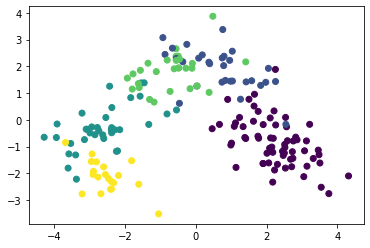

In [85]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5)
y_predict_wine = agg.fit_predict(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

A benefit of hierarchical clustering is that the number of clusters can be changed after performing the clustering. The number of clusters is usually selected based on a visualization (dendrogram) of the clustering hierarchy. Unfortunately, there's no function that we can use to plot the dendrogram of the `AgglomerativeClustering` class. Thus, we will use `scipy.cluster.hierarchy` functions for clustering and plotting the dendrogram.

In [86]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_wine, method='ward', optimal_ordering=True)
Z

array([[  9.        ,  47.        ,   1.16411367,   2.        ],
       [131.        , 133.        ,   1.19160238,   2.        ],
       [ 12.        ,  11.        ,   1.20935571,   2.        ],
       [ 53.        ,  15.        ,   1.22551046,   2.        ],
       [ 92.        , 107.        ,   1.24538798,   2.        ],
       [ 34.        ,  37.        ,   1.26841838,   2.        ],
       [ 20.        ,   0.        ,   1.28789316,   2.        ],
       [ 16.        ,  17.        ,   1.2917937 ,   2.        ],
       [172.        , 164.        ,   1.30048379,   2.        ],
       [ 22.        ,  29.        ,   1.33566687,   2.        ],
       [ 40.        ,  56.        ,   1.34447772,   2.        ],
       [104.        , 116.        ,   1.3521749 ,   2.        ],
       [ 24.        ,  23.        ,   1.36268788,   2.        ],
       [ 38.        ,  27.        ,   1.3653111 ,   2.        ],
       [140.        , 142.        ,   1.36740174,   2.        ],
       [ 63.        ,  98

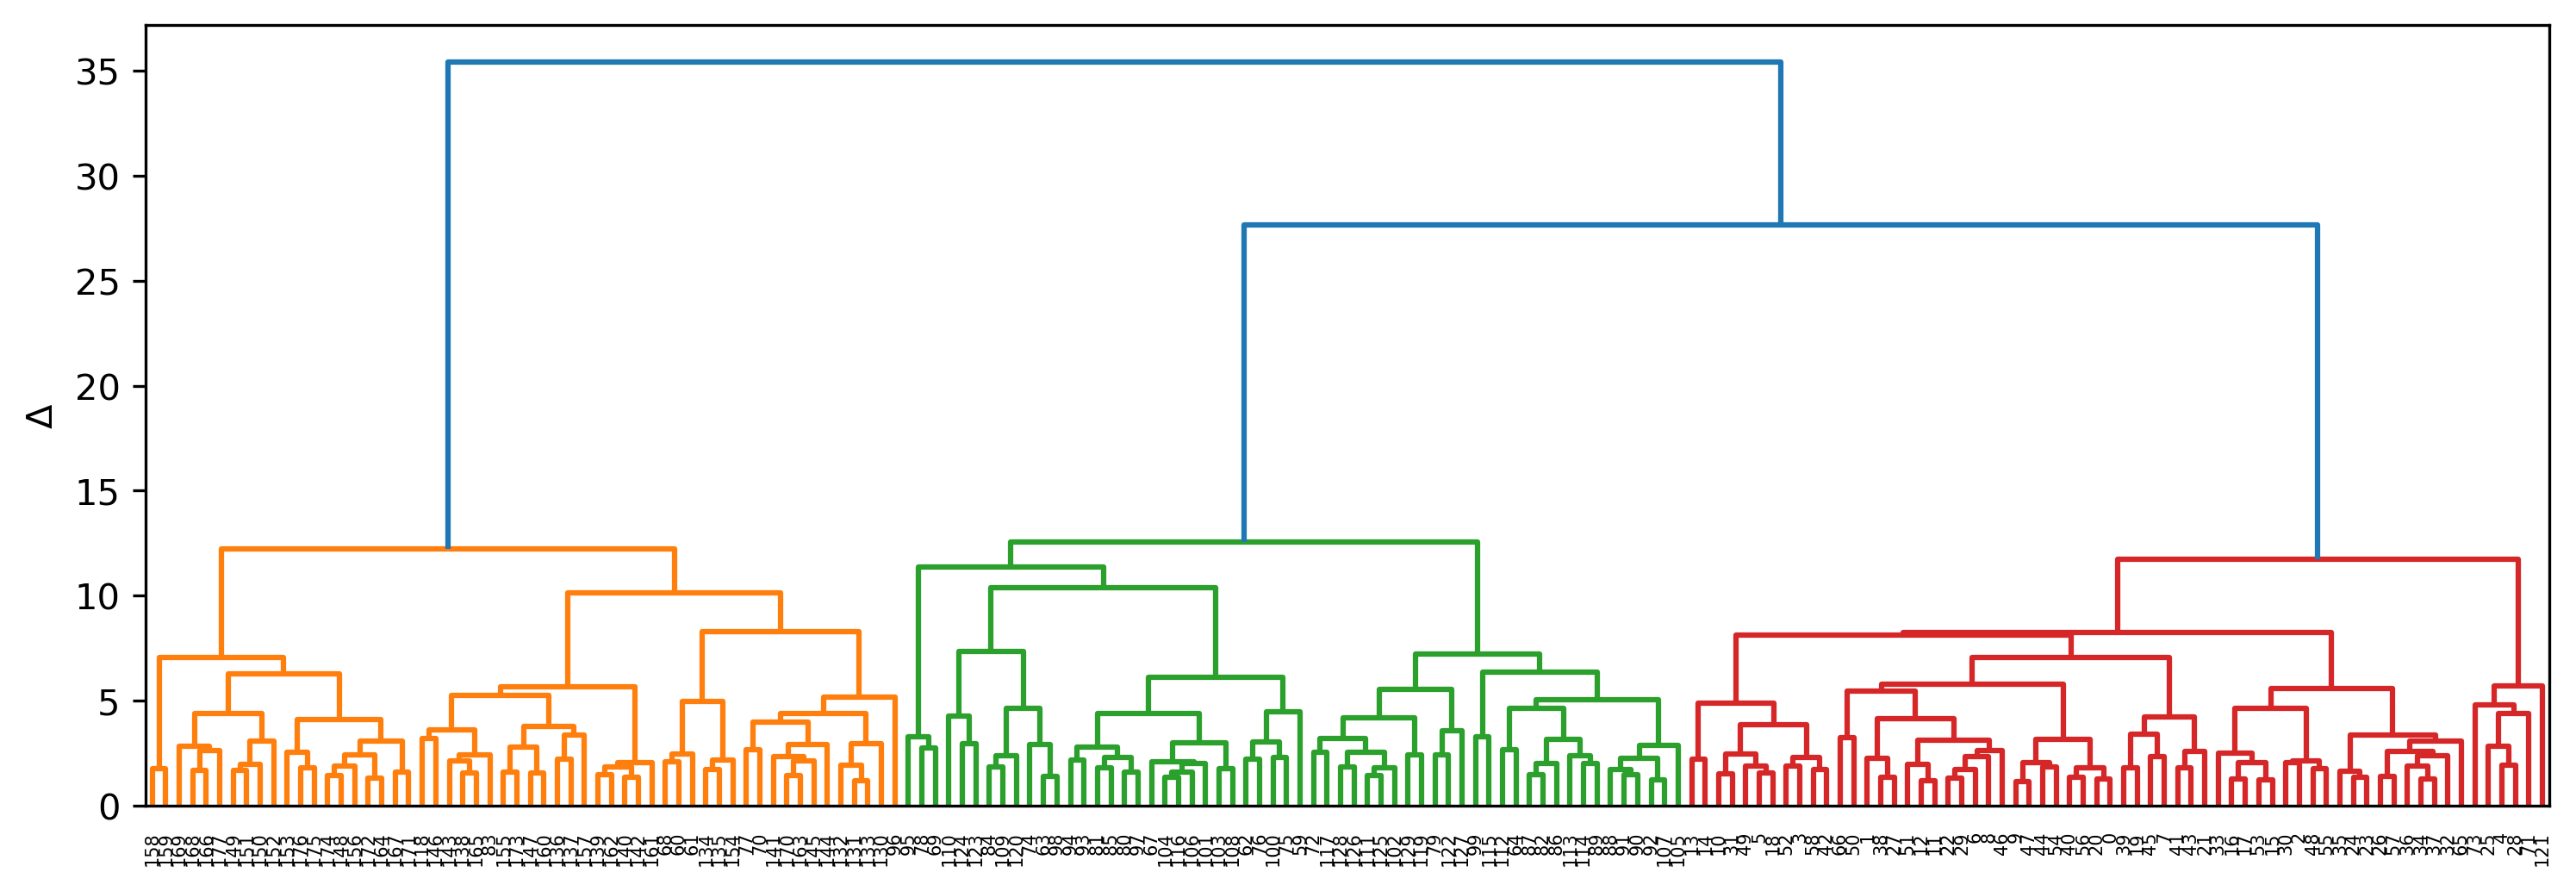

In [87]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$');

dendrogram?

The dendrogram is too crowded so let's try to clean it up a bit.

**Exercise 14**

Create a function `plot1` that accepts the output of linkage and replicates the plot below.

![](plot1.png)

notes:
- (6) means there are 6 points represented in this leaf
- the documentation sets the threshold of 0.8xlargest value, keep in mind this doesnt mean the clusters produced using this default parameter is not always correct. you need to determine the threshold urself 

In [154]:
def plot1(Z):
    """Plot the dendogram of linkage.

    Parameters
    ----------
    Z : linkage matrix
    
    Returns
    -------
    ax: matplotlib.pyplot axes object
    """
    Z = linkage(X_wine, method='average', optimal_ordering=True)
    p = 16
    fig, ax = plt.subplots()
    dn = dendrogram(Z, truncate_mode='lastp',p=p, ax=ax, color_threshold = 4.9)
    ax.set_ylabel(r'$\Delta$')
    return ax

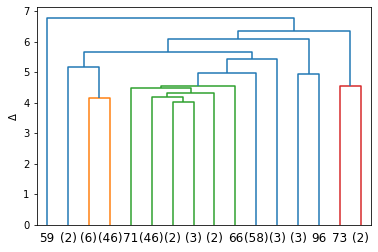

In [107]:
ax = plot1(Z)
ax.figure.savefig('plot1-test.png')
assert compare_images('plot1.png', 'plot1-test.png', tol=50) is None

We assign each point to a flat cluster using `fcluster`.

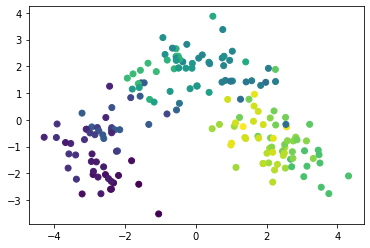

In [109]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=4.9, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 15**

Cluster the newsgroups dataset using Ward's method. What's the best value of $k$? Justify your answer.

YOUR ANSWER HERE

The best value for k would be k=2, since there is a big gap in the delta where there is no merging observed. The threshold for having 2 clusters would start at delta at 2.5. One could also opt for a delta = 2.0 where k would be equal to 3, however k=2 still remains more fitting because the clusters would be balanced at that level. 

In [116]:
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)
Z

array([[3.97000000e+02, 2.92000000e+02, 0.00000000e+00, 2.00000000e+00],
       [8.70000000e+02, 1.07100000e+03, 0.00000000e+00, 2.00000000e+00],
       [7.78000000e+02, 5.47000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.24900000e+03, 2.25000000e+03, 1.69508549e+00, 5.64000000e+02],
       [2.25100000e+03, 2.24700000e+03, 2.21094606e+00, 5.64000000e+02],
       [2.25200000e+03, 2.25300000e+03, 4.05237070e+00, 1.12800000e+03]])

Text(0, 0.5, '$\\Delta$')

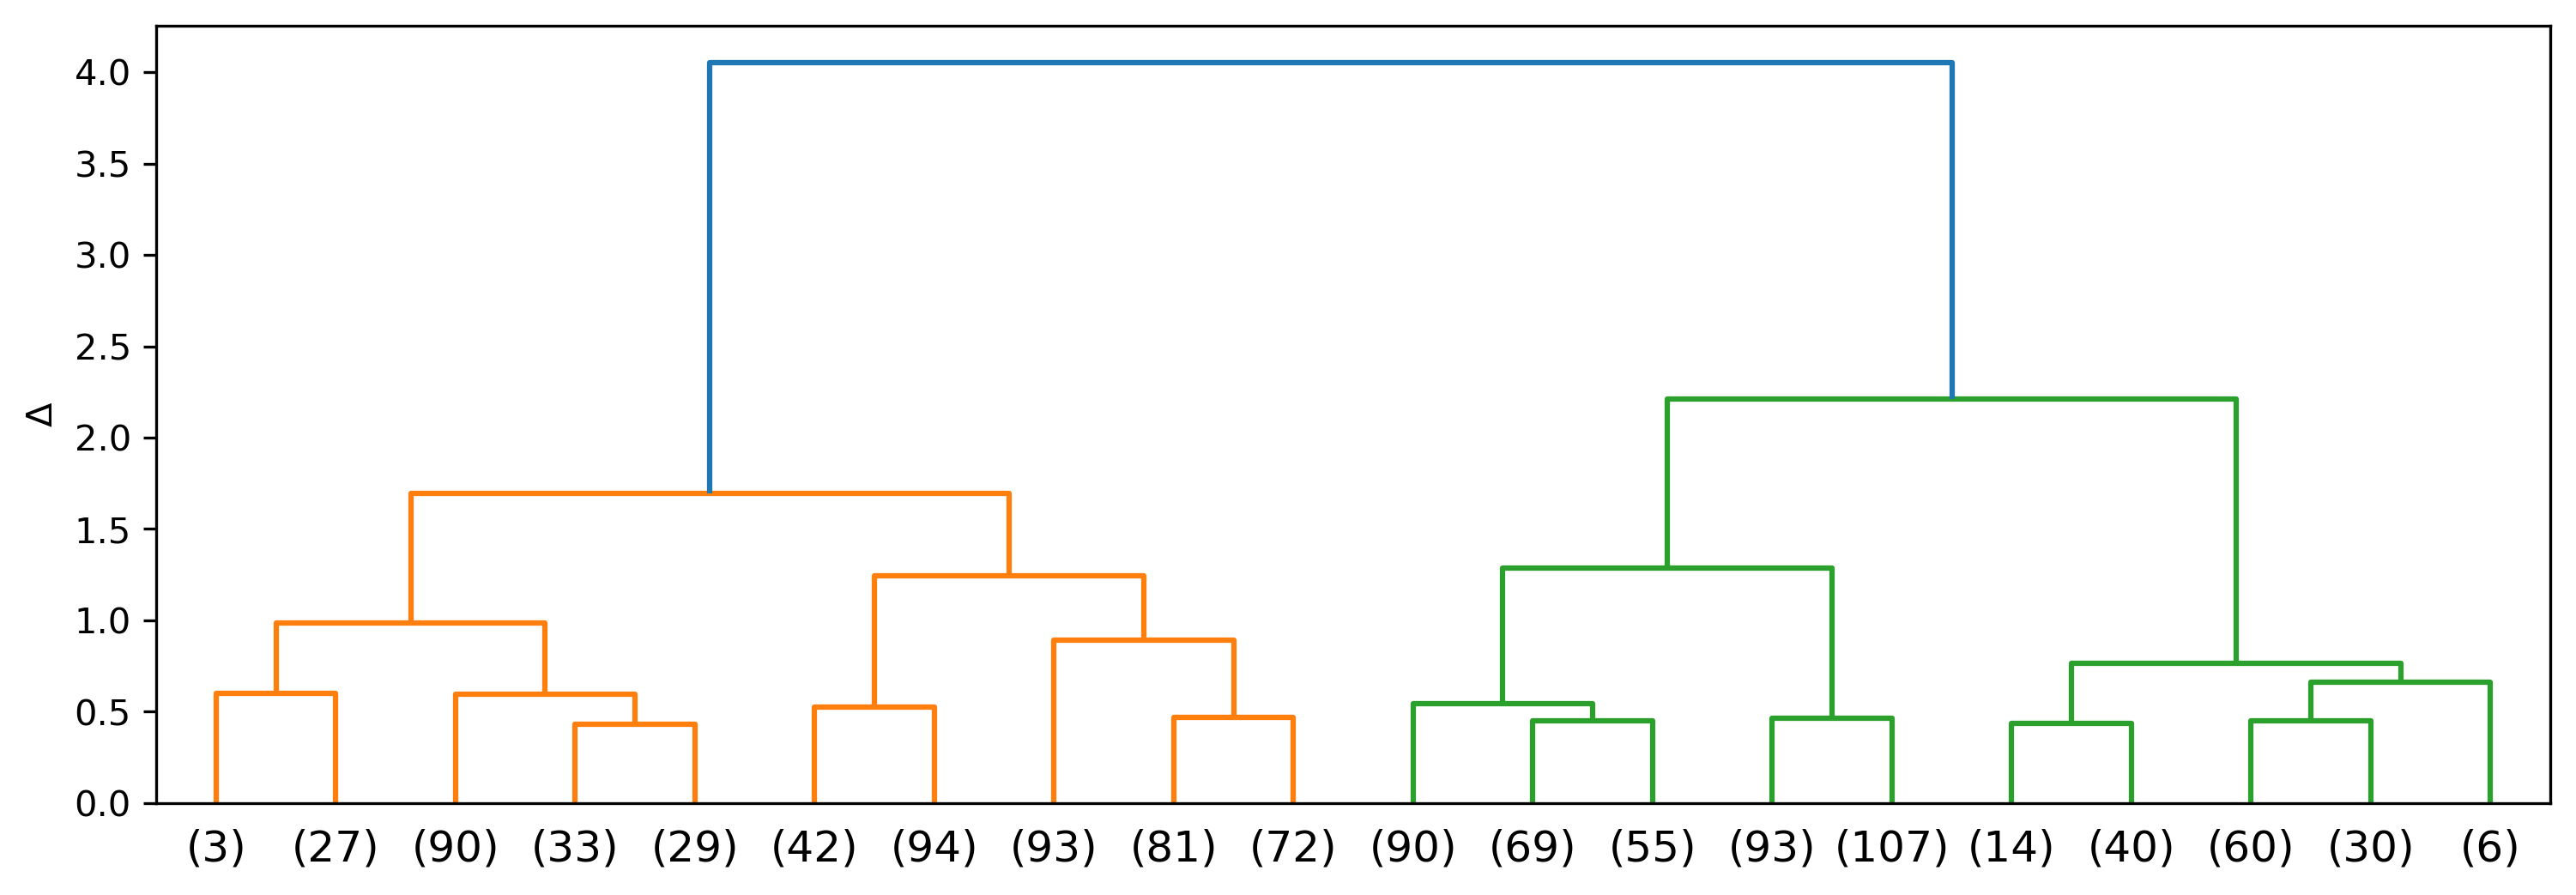

In [117]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

dn = dendrogram(Z, ax=ax, truncate_mode='lastp', p=20)

ax.set_ylabel(r'$\Delta$')

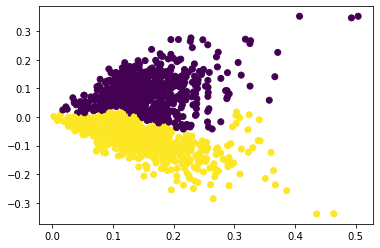

In [119]:
# Check clustering through scatterplot
# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=2.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

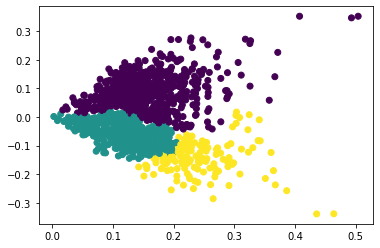

In [120]:
# Check clustering through scatterplot
# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=2.0, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Single linkage

Single linkage uses the smallest intercluster distance as the metric. Let's try it on the wines dataset.

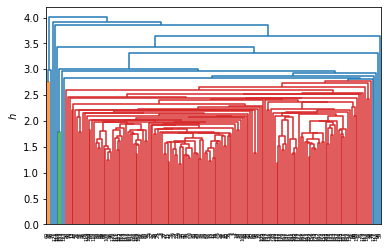

In [121]:
Z = linkage(X_wine, method='single', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

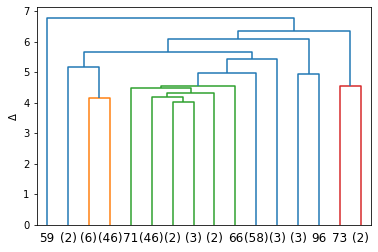

In [122]:
plot1(Z);

This will be the clustering if we set the threshold to 3.

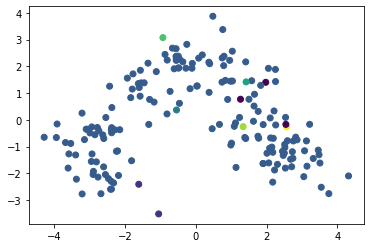

In [124]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=3.0, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 16**

Why is the clustering worse than with Ward's method?

YOUR ANSWER HERE

Single linkage just tries to merge based on the nearest neighboring cluster. A measurement based on one pair cannot fully reflect the distribution of documents in a cluster. Single-link clustering can produce straggling clusters. A chain of points can be extended for long distances without regard to the overall shape of the emerging cluster. Ward's however, considers not just the measurement of one pair, but the measurement of all points relative to the centroid of the cluster. It consideres the overall shape of the cluster. As seen in the plot, most of the points belong to 1 dominant cluster. This creates an imbalance to the distribution of points for each cluster.

**Exercise 17**

Cluster the newsgroups dataset using single linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

YOUR ANSWER HERE

The best value for k would be k=3 at threshold equals 0.9. The plot shows that majority of the points belong to 1 dominant cluster, while the remaining clusters contain outliers. Note that single linkage does not provide good clustering on this example given the strong imbalances between clusters. 

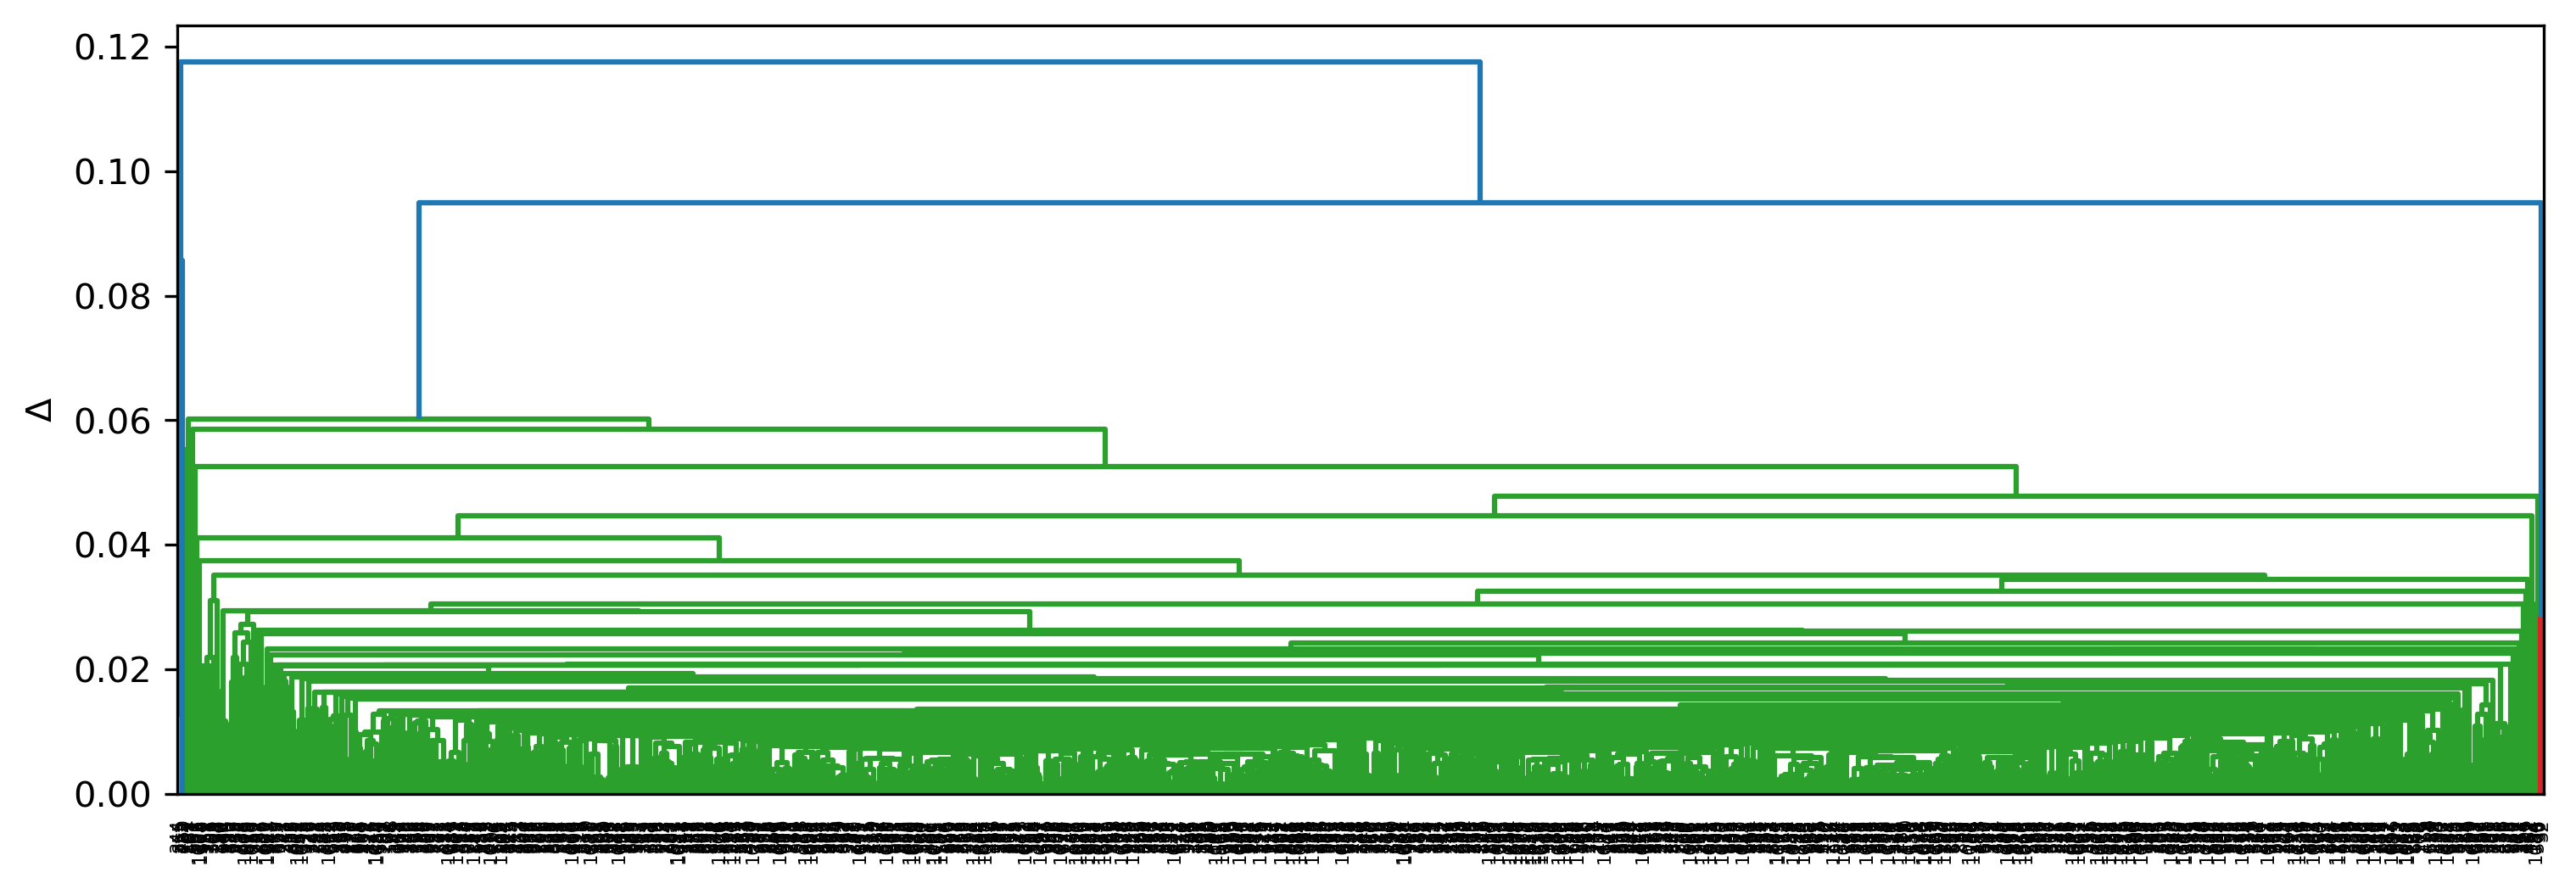

In [125]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Single-linkage
Z = linkage(X_ng_new, method='single', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

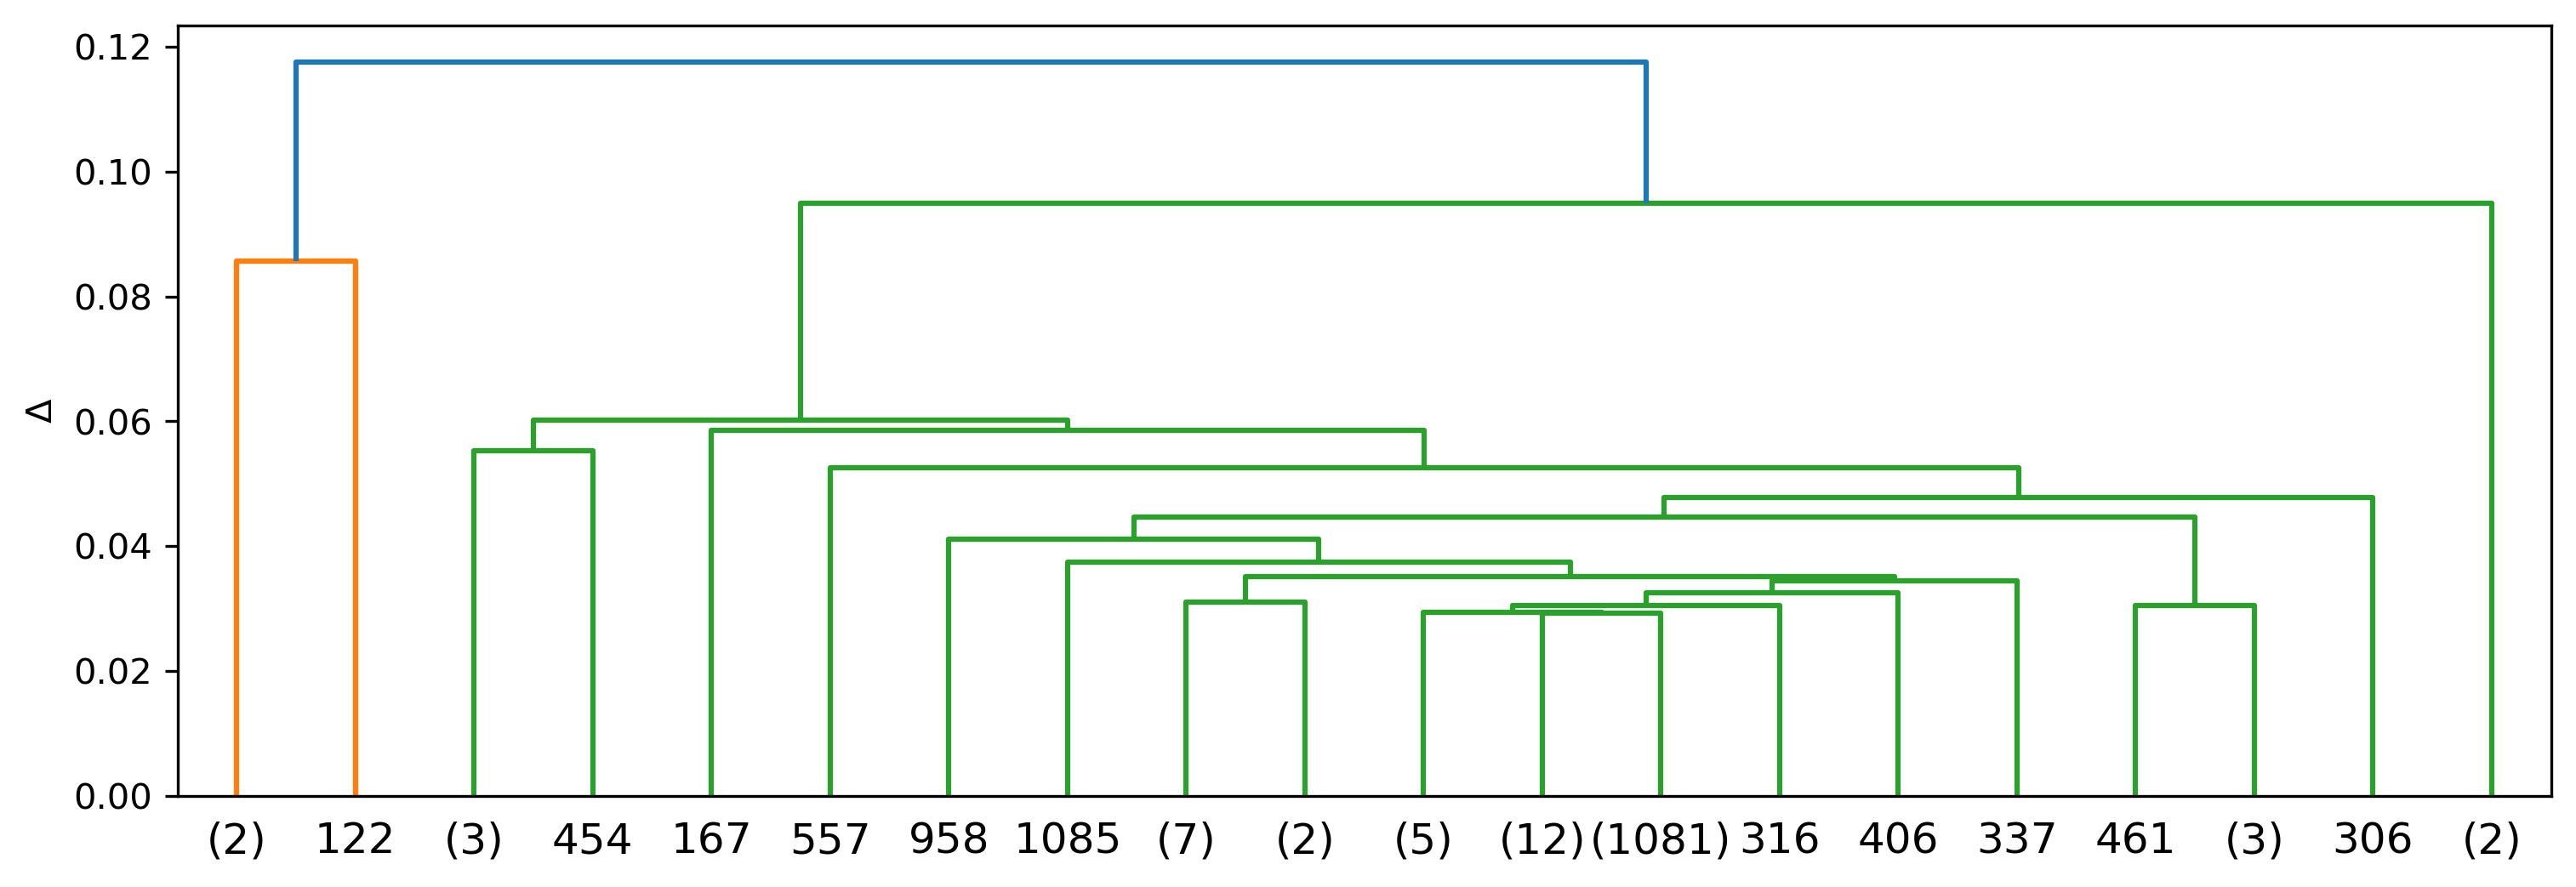

In [132]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Single-linkage
Z = linkage(X_ng_new, method='single', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=20, ax=ax, color_threshold=0.1)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

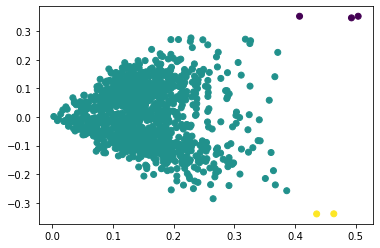

In [136]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=0.091, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Complete linkage

Complete linkage uses the largest intercluster distance as the metric. Let's try it on the wines dataset.

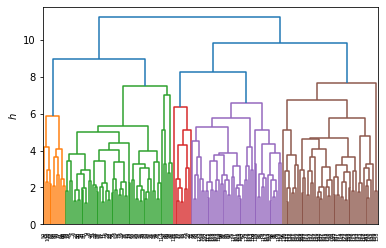

In [137]:
Z = linkage(X_wine, method='complete', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

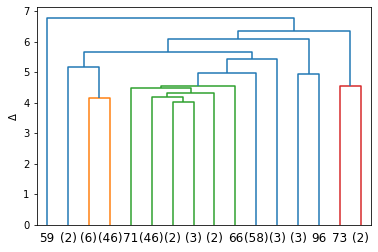

In [138]:
plot1(Z);

This will be the clustering if we set the threshold to 9.

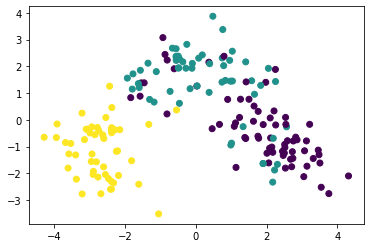

In [140]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=9, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 18**

Compare the clustering with those of Ward's method and single linkage. Is complete linkage better or worse than other methods?

YOUR ANSWER HERE

Single linkage is the worst among the three, given that it suggested that there is only 1 major cluster (imbalanced clusters). Complete linkage is better than single linkage, given that the points are relatively more distributed evenly to the clusters. However, it is not better than ward's method because the degree of separation of clusters are better using ward's method. 

**Exercise 19**

Cluster the newsgroups dataset using complete linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

YOUR ANSWER HERE

The best k is k=2, at threshold equal to 3.0. At two clusters, the points are evenly distributed and compact. Also, this threshold value appears lie in the largest gap where there is no merging observed. 

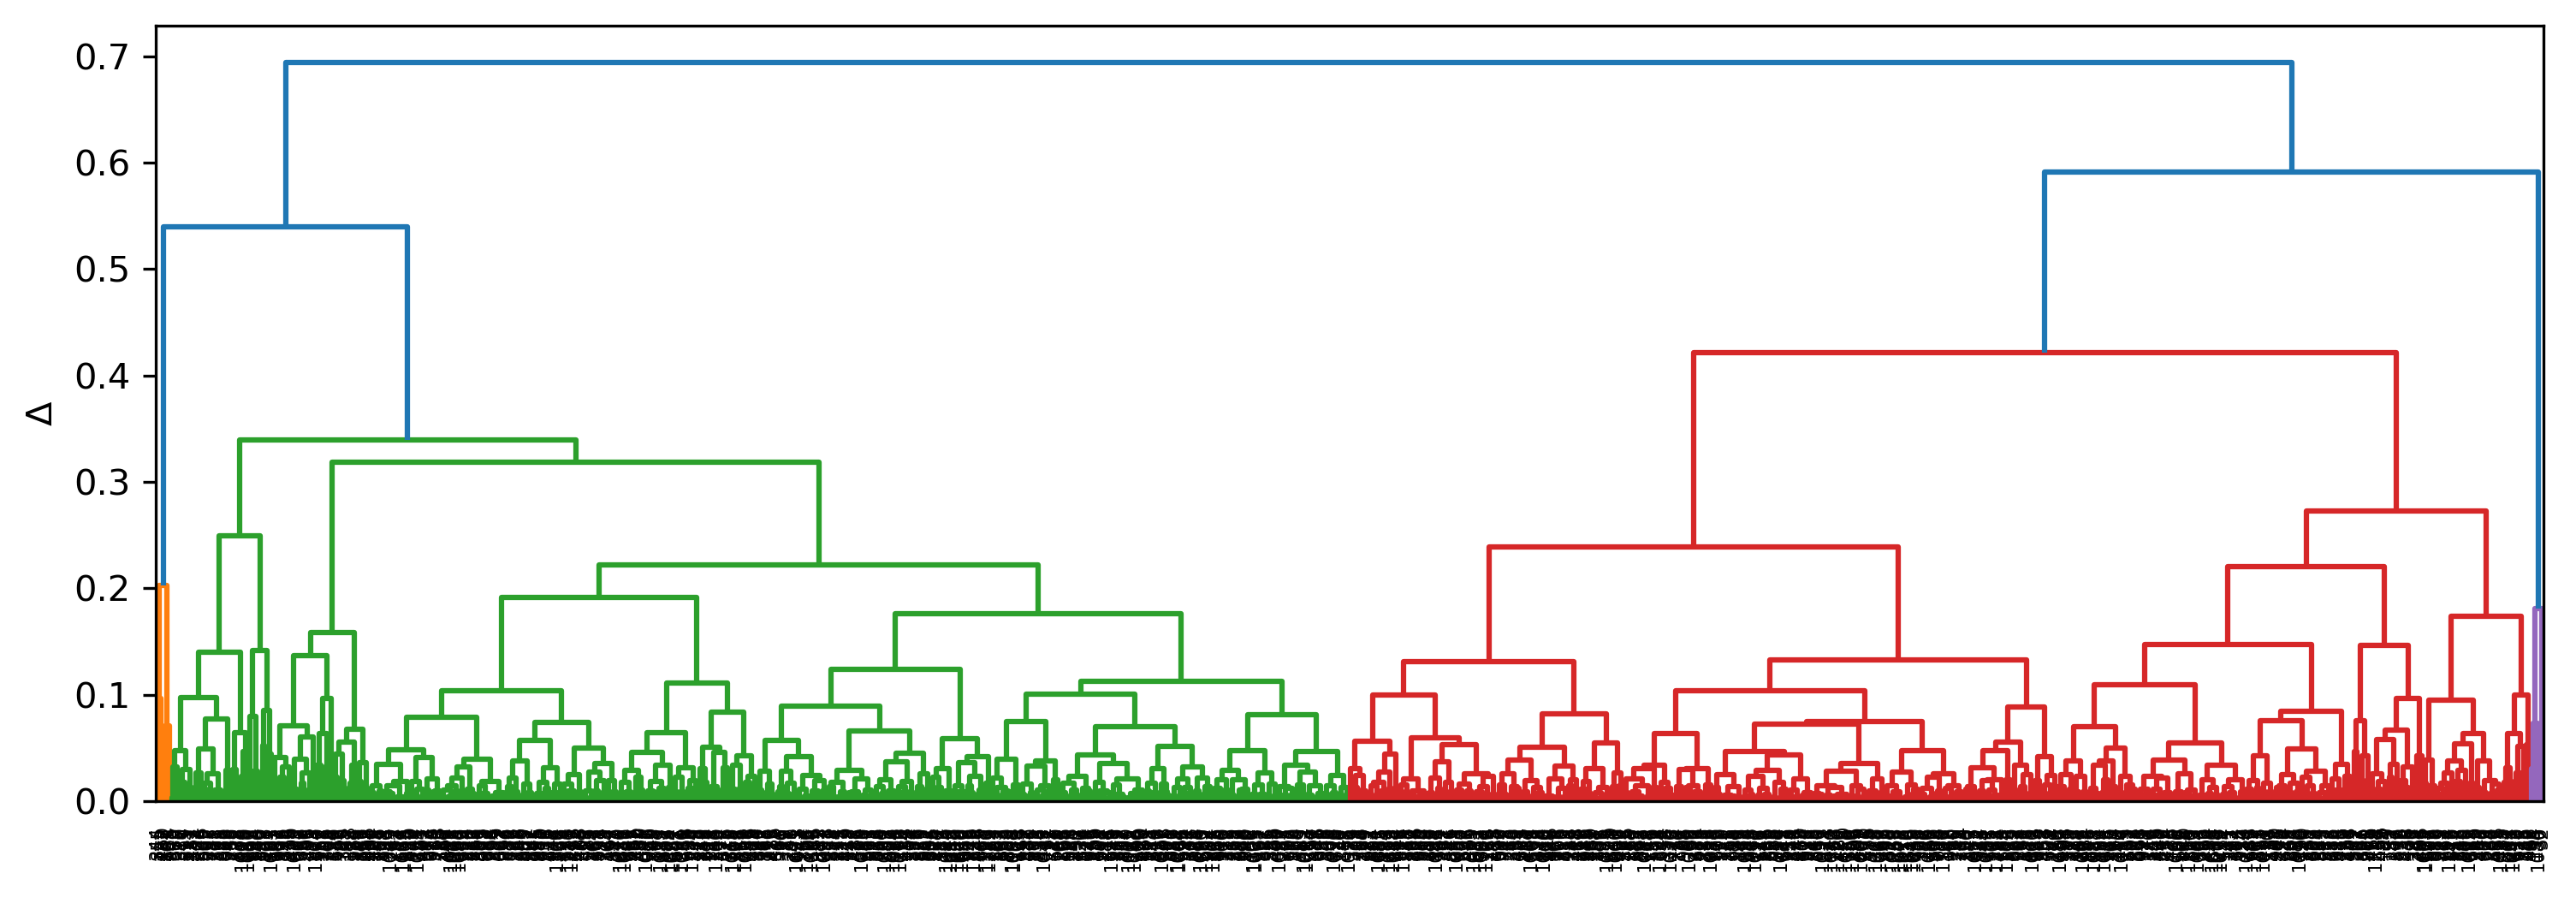

In [141]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Complete-linkage
Z = linkage(X_ng_new, method='complete', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

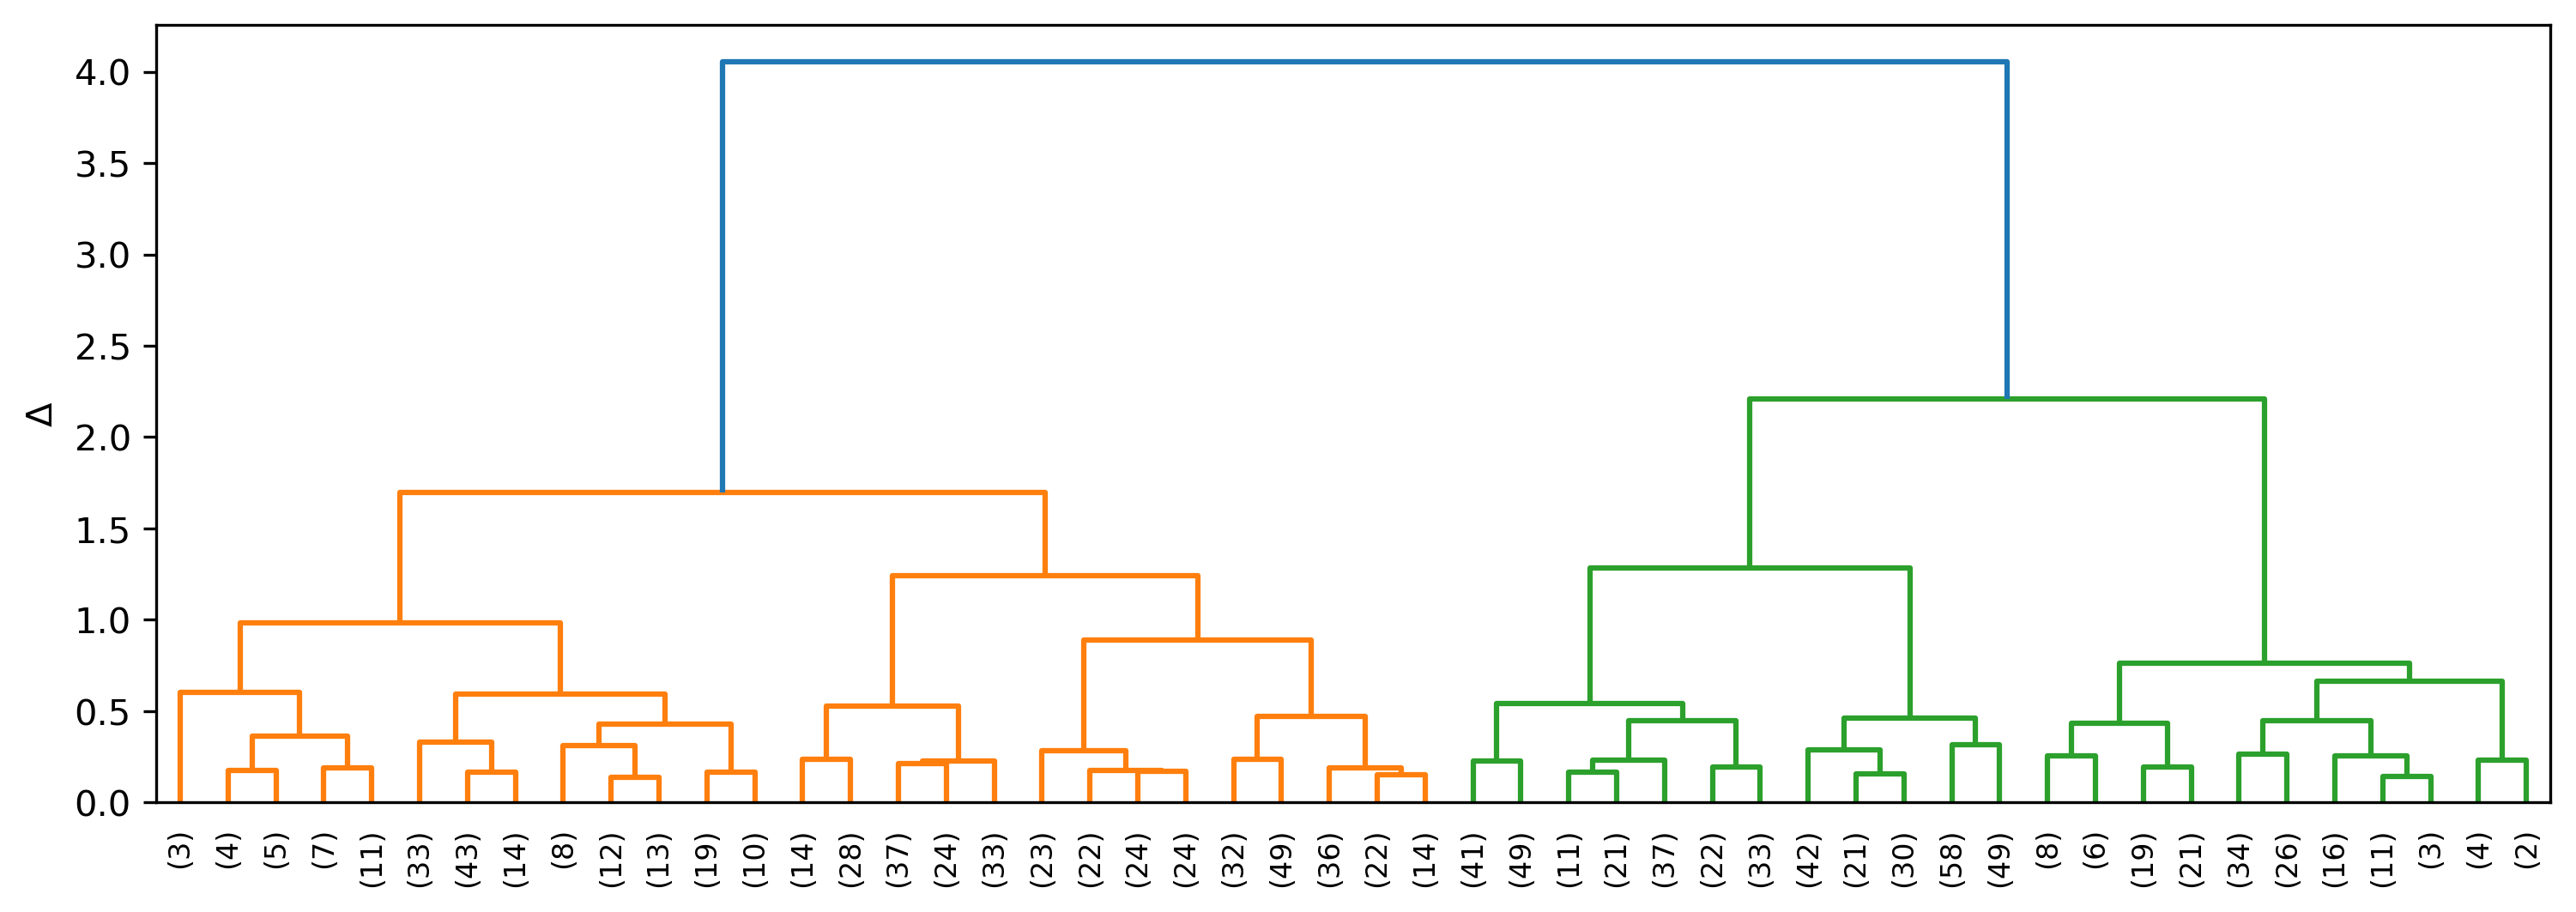

In [142]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Complete-linkage
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=50, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

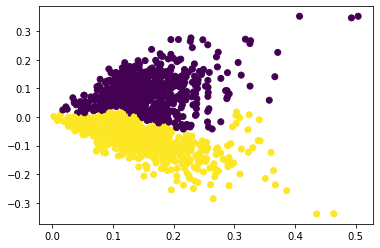

In [143]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=3.0, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Average linkage

Average linkage uses the average intercluster distance as the metric. Let's try it on the wines dataset.

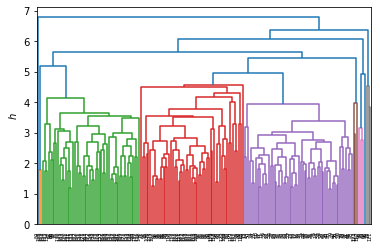

In [144]:
Z = linkage(X_wine, method='average', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, color_threshold=4.8, ax=ax)
ax.set_ylabel(r'$h$');

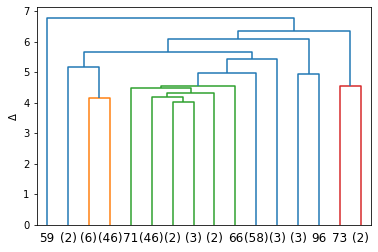

In [145]:
plot1(Z);

This will be the clustering if we set the threshold to 4.5.

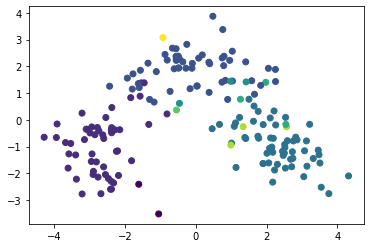

In [146]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=4.8, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 20**

Compare the clustering with those of Ward's method, single linkage and complete linkage. Is average linkage better or worse than other methods?

YOUR ANSWER HERE

Average link is the midpoint of single and complete linkage. It is better than both. The degree of overlapping is better than both single and complete linkage. However, ward's still remains the best among all methods as its compactness, balancedness, and separability is best. 

**Exercise 21**

Cluster the newsgroups dataset using average linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

YOUR ANSWER HERE

The best k would be k=2 at threshold value equal to 2.5, given that there are minimal overlapping observed at k=2. The clusters appear to be more balanced and compact as well compared to other values of k. 

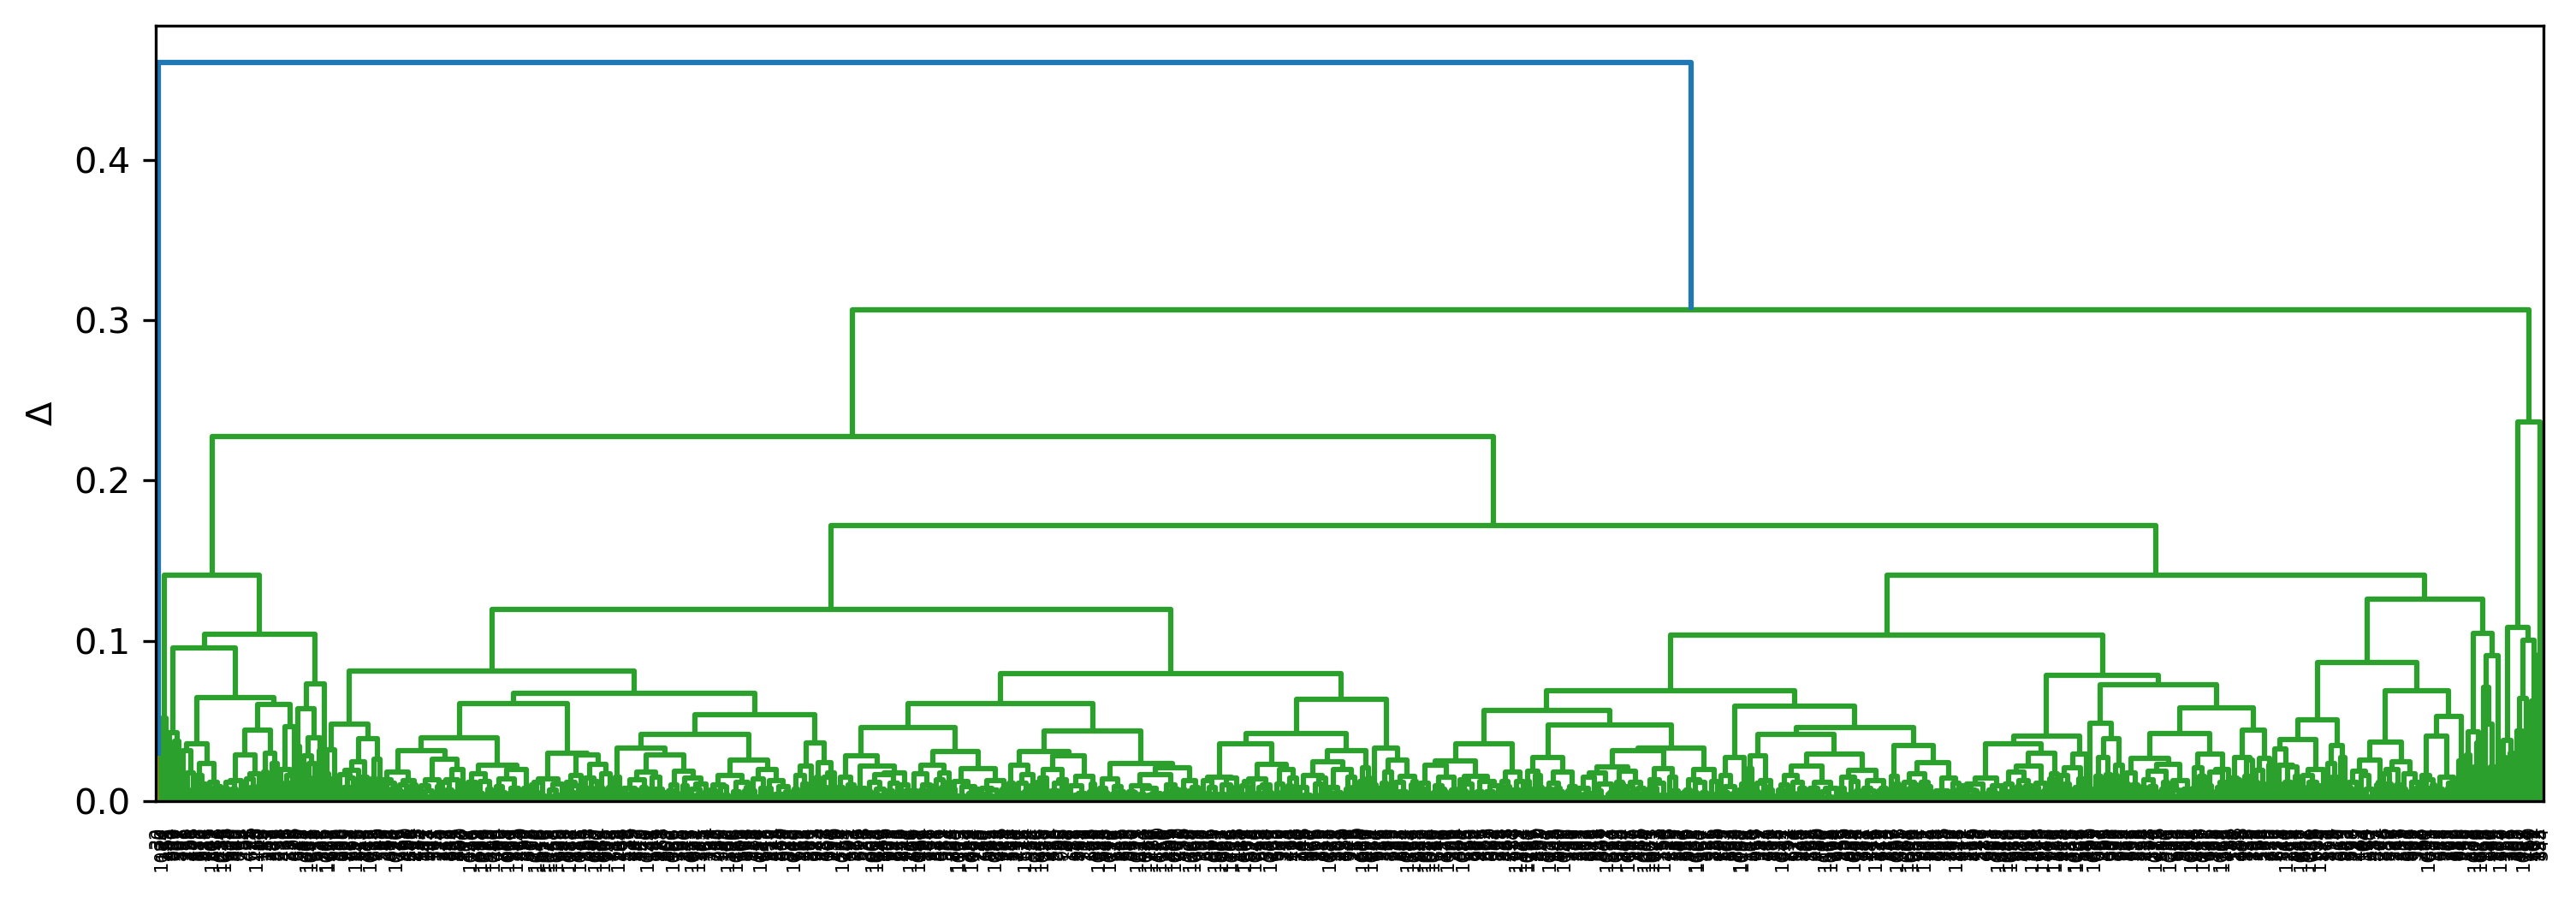

In [147]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Average-linkage method
Z = linkage(X_ng_new, method='average', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

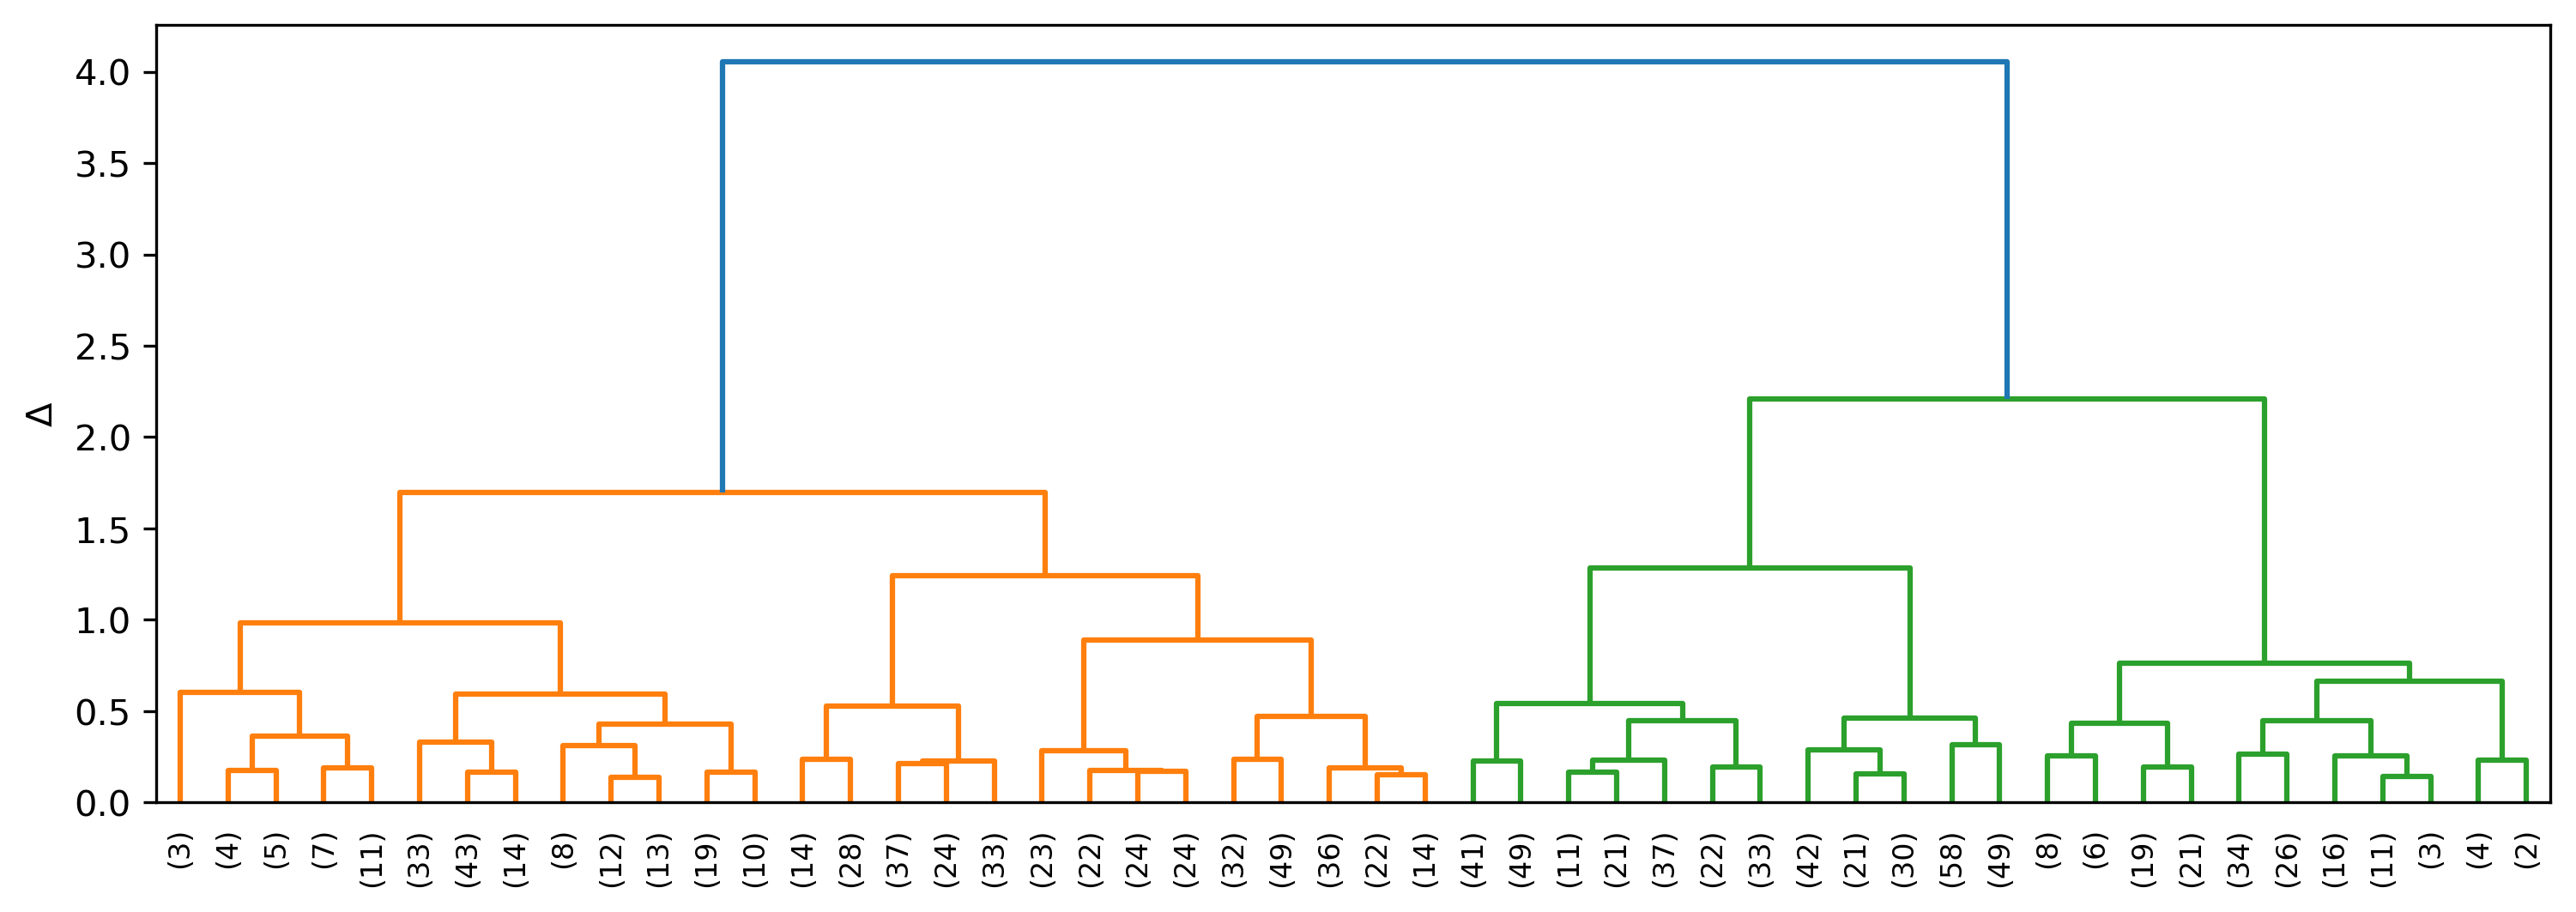

In [148]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Average-linkage method
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=50, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

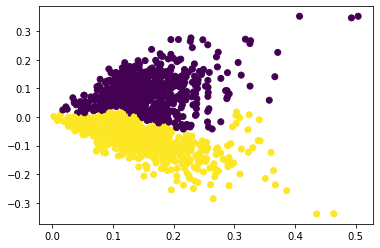

In [152]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=2.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

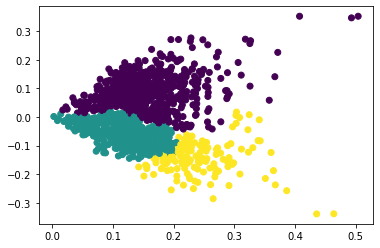

In [153]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=2.0, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

# References
* C. Shalizi, Statistics 36-350 lecture notes, http://www.stat.cmu.edu/~cshalizi/350/lectures/07/lecture-07.pdf
* C. Aggarwal, Data Mining: The Textbook, Chapter 6.

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
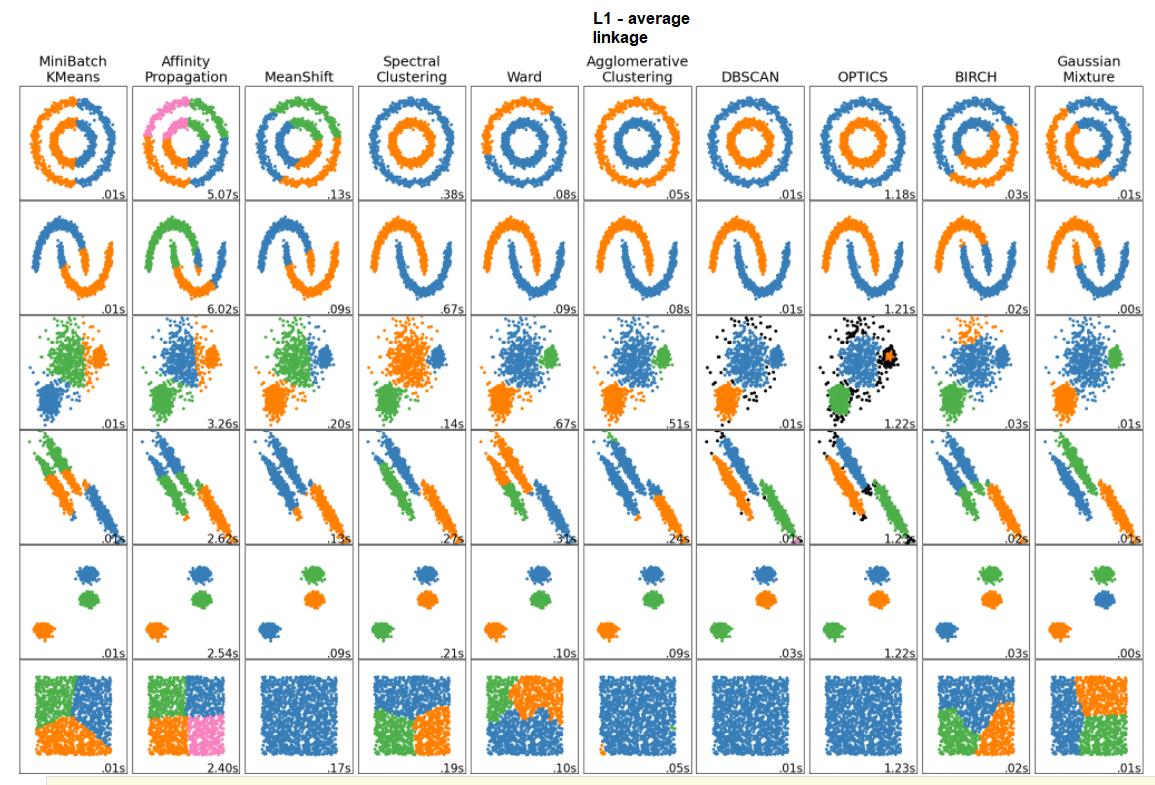